In [2]:
import json
import os
import tweepy
import pandas as pd
import re
import string
from textblob import TextBlob
from nltk.corpus import stopwords
import matplotlib.pyplot as plt




**COVID-19 Twitter Clustering using K-Means:**

Given the vast influx of information surrounding the COVID-19 pandemic and it's exponential transmission via various social networking platforms, it is difficult for users to coherently process all of the surrounding buzz. Social media sites such as facebook and twitter generate ad-revenue based on user engagement which allows for rumours and misinformation to spread like wildfire. Due to the broad scope and lack of relevantly labeled data, we will not focus on identifying misinformation. Instead, we will attempt to give the user a new point-of-reference for digesting social media.
By topically clustering tweets via the use of a variety of NLP and ML techniques, we will offer a new lens into the COVID-19 pandemic that can help users digest information in a much simpler manner. The interactive dash app we create will aid in understanding the information dynamics between twitter users and the coronavirus.

This assignment will cover the following:
- Web scraping and Data 
- Preprocessing and Feature Engineering
- Sentiment Analysis TextBlob (brief insight)
- SpaCy tokenization 
- Vectorization (TF-IDF/BOW) and Dimensionality reduction via PCA 
- K-means clustering model 
- t-SNE for visualization
- Dash-app [1]


In [3]:
#accessing credentials file to scrape twitter API
# with open(credentials) as cred_data:
#         info = json.load(cred_data)
#         consumer_key = info['CONSUMER_KEY']
#         consumer_secret = info['CONSUMER_SECRET']
#         access_key = info['ACCESS_KEY']
#         access_secret = info['ACCESS_SECRET']
#         #google_api = info['GOOGLE_API']
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_key, access_secret)
# api = tweepy.API(auth, wait_on_rate_limit=True)

Adding relvant"coronavirus" search words and setting time frame to tweets since May 1, 

In [4]:
# search_words = ['coronavirus']
# date_since = '2020-05-01'

In [5]:
# #using tweepy.Cursor to format dataframe
# tweets = tweepy.Cursor(
#    api.search,
#    q = search_words,
#    lang = 'en',
#    since = date_since,
#    tweet_mode='extended' #attempt to retrieve fill_text from truncated tweets
# ).items(1500)

In [6]:
#collecting tweet user and location data avaiable (we settled on one dataframe for this project)
#tweet_details = [[tweet.full_text, tweet.user.screen_name, tweet.user.location] for tweet in tweets]
#tweet_df = pd.DataFrame(data=tweet_details, columns=['text','user','location'])

#Reading in Data from the Twitter Chatter Data Set: Juan

In [7]:
#reading in a version of the df for consistency
pd.set_option('max_colwidth',800)
tweet_df = pd.read_csv('twitter_data.csv')
tweet_df.head()

,text,user,location
0,"RT @azcentral: JUST IN: The Arizona Department of Health Services told a team of university experts working on COVID-19 modeling to ""pause""…",DesertCarmen,"Chandler, AZ"
1,RT @FOX5Vegas: UPDATE: Drive-thru COVID-19 is underway at the Orleans hotel-casino. @dylankendricktv explains how the appointment-only test…,charlienicole,"Nevada, USA"
2,"RT @JenningsK12: @CareSTLHealth has created a new COVID-19 testing site at Fairview Elementary School, 7047 Emma Ave, St. Louis, MO 63136.…",CareSTLHealth,St. Louis
3,RT @InclusionPhilly: Thanks to @nbcphiladelphia and @mitchreports for a great interview profiling our efforts at @theFPCN to expand testing…,mitchreports,"Philadelphia, PA"
4,"RT @WSJ: Covid-19 is taking workplace surveillance to a higher level, with some employers planning to track movements and gather personal i…",KELLYCLELLAND1,Lothian


In [8]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      1500 non-null   object
 1   user      1500 non-null   object
 2   location  1020 non-null   object
dtypes: object(3)
memory usage: 35.3+ KB


* since we are only dealing with english tweets collected over a short period of time, we found that locational data inconsistently collected 
  - (Liverpool, England; Liverpool UK, Scottsdale Arizona, Scottsdale AZ, USA 16253, ¯\_(ツ)_/¯ NYC, NY USA, Ireland) 
* Emojis, hashtags, truncated RT, hyperlinks
 Given that we only scrape a few thousands tweets at a time from a specified date we are able to hone in on the textual data and it's lifecycle.

Relying solely on metadata (retweets/mentions/location/time) would deduct from the value of the unique approach we are attempting.
 
This philosophy allows us to fully leverage NLP techniques that can be integrated into an unsupervised learning algorithm to visualize tweets in a nuanced way. This is a refereshing vantage point for viewing covid-data that makes our project unique by pushing the boundaries of NLP and ML in a uniquely textual form to help visualize a different story. 

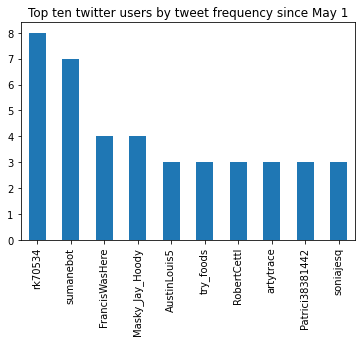

In [9]:
#plotting top ten twitter. users by tweet freq. 
tweet_df.user.value_counts()[:10].plot(kind='bar',title='Top ten twitter users by tweet frequency since May 1')
#data['title'].value_counts()

#tweet_df.location.value_counts()

# Preprocessing and feature engineering:
We are not reinventing the wheel in terms of preprocessing twitter data. Numerous NLP publications regarding twitter preprocessing refer to boilerplate helper functions for cleaning tweets.[4] Combining the use of regular expressions to address the formatting styles of Covid-19 tweets, we have developed the following

Hyperlinks, special characters and emojis were removed. Due to the white-space generated, white spaces and newline characters also were filtered out. Cleaned text was also lower-cased  to aid initial NLP preprocessing.




In [10]:
# clean tweet
def clean_tweet(tweet):
    # Remove hyperlinks
    tweet = re.sub("https?://[A-Za-z0-9./]*","",tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    #@user -> at_user
    tweet = re.sub("@[\w]*","",tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words: I, a , am, me (2 or less letters)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove emojis or other. special characters
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet  

In [11]:
from string import punctuation
#extracting hashtags as a means of possible cluster validation  
def extraxt_hashtags(text):
  hashtags = re.findall(r'\B#\w*[a-zA-Z]+\w*', text)
  return hashtags

Hashtags allow the author of the tweet to distill the main points they are trying to ascertain. Although many empty fields are found following this extraction, the hashtags could provide a manual way for our group to intuitively label the gist of each tweet instantly. If someone tweets [#COVID,#conspiracy] vs [#PrayforOurHealthProfessionals, "#rona] then we have two starkly different view points (most likely) that we can instantly distinguish with #hashtags over the content of the tweet itself. This was an interesting idea to wrestle with in the context of this project.

In [12]:
tweet_df['hashtag'] = tweet_df['text'].apply(lambda x: extraxt_hashtags(x))
tweet_df['clean_text'] = tweet_df['text'].apply(lambda x: clean_tweet(x))
tweet_df.head()

,text,user,location,hashtag,clean_text
0,"RT @azcentral: JUST IN: The Arizona Department of Health Services told a team of university experts working on COVID-19 modeling to ""pause""…",DesertCarmen,"Chandler, AZ",[],just the arizona department health services told team university experts working covid modeling pause …
1,RT @FOX5Vegas: UPDATE: Drive-thru COVID-19 is underway at the Orleans hotel-casino. @dylankendricktv explains how the appointment-only test…,charlienicole,"Nevada, USA",[],update drive thru covid underway the orleans hotel casino explains how the appointment only test…
2,"RT @JenningsK12: @CareSTLHealth has created a new COVID-19 testing site at Fairview Elementary School, 7047 Emma Ave, St. Louis, MO 63136.…",CareSTLHealth,St. Louis,[],has created new covid testing site fairview elementary school 7047 emma ave louis 63136 …
3,RT @InclusionPhilly: Thanks to @nbcphiladelphia and @mitchreports for a great interview profiling our efforts at @theFPCN to expand testing…,mitchreports,"Philadelphia, PA",[],thanks and for great interview profiling our efforts expand testing…
4,"RT @WSJ: Covid-19 is taking workplace surveillance to a higher level, with some employers planning to track movements and gather personal i…",KELLYCLELLAND1,Lothian,[],covid taking workplace surveillance higher level with some employers planning track movements and gather personal …


# A Cursory Glance at tweet sentiment via Text Blob:
Instead of training a classifier (NBC/GBM) for identifying the sentinment on a granular scale (disgust, anxiety, positive ...) which would require vast amounts of labeled data and preferabbly SpaCy, we decided to settle in on TextBlob, a much simpler library in order to scale tweets based on polarity and subectivity between 0 and 1. This would allow us to investigate trends in clustered data in terms of guaging a high level sentimental overview of tweets that garnered the most attenntion. Although this is not the primary focus of this project, it's extensive research has inclined us to merely approach this problem from a point of topic modeling. The user can then form their own opinions on this topic and choose if they would like to hear more about it. Sentiment analysis would be a wonnderful thing to geolocationaly map and track over time however we feel that work done by the CoMune lab (Information Risk Index by country,  big 5 personality scores of regions) has been a phenomenal academic venture that has already been covered in depth. 



In [13]:
tweet_df['sentiment'] = tweet_df['clean_text'].apply(lambda tweet: TextBlob(tweet).sentiment)
#seperate polarity and subjectivity in to two variables

- Splitting sentiment score tuples into inndividual polarity and subjectivity columns, respectively

Each word in lexicon then has scores for:
- 1)     polarity: negative vs. positive    (-1.0 to +1.0)
- 2) subjectivity: objective vs. subjective (+0.0 to +1.0)

In [14]:
tweet_df['polarity'], tweet_df['subjectivity'] = tweet_df.sentiment.str

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [15]:
tweet_df.drop('sentiment',axis=1,inplace=True)#dropping sentiment class so dash app can process it

** Data Quality Issues **
- RT, @, emojis, coronavirus
- loss of data/information from media removal(stripping the links)
- Twitter Data vs. Regular Text 

Tweets are highly distinguished from regular textual data given their 140 character-limit and ubiquitous use of slang, hashtags and emojis. Furthermore, the use of embedded metadata such as hyper-links, GIFS, and images enables users to devour a higher volume of content much faster than ever before. Twitter’s platform has effectively restructured the way in which we process data; rewarding users with the currency of retweets, favorites and verification. This change calls for a few fundamentally different approaches to traditional NLP techniques to help us understand information transmission. We will elaborate on this idea throughout the course of this work. 


In [16]:
#tweet_df.to_csv('clean.csv',mode='a', header=True)#appending each time
df = tweet_df
df.head()

,text,user,location,hashtag,clean_text,polarity,subjectivity
0,"RT @azcentral: JUST IN: The Arizona Department of Health Services told a team of university experts working on COVID-19 modeling to ""pause""…",DesertCarmen,"Chandler, AZ",[],just the arizona department health services told team university experts working covid modeling pause …,0.000000,0.000000
1,RT @FOX5Vegas: UPDATE: Drive-thru COVID-19 is underway at the Orleans hotel-casino. @dylankendricktv explains how the appointment-only test…,charlienicole,"Nevada, USA",[],update drive thru covid underway the orleans hotel casino explains how the appointment only test…,0.000000,1.000000
2,"RT @JenningsK12: @CareSTLHealth has created a new COVID-19 testing site at Fairview Elementary School, 7047 Emma Ave, St. Louis, MO 63136.…",CareSTLHealth,St. Louis,[],has created new covid testing site fairview elementary school 7047 emma ave louis 63136 …,0.218182,0.677273
3,RT @InclusionPhilly: Thanks to @nbcphiladelphia and @mitchreports for a great interview profiling our efforts at @theFPCN to expand testing…,mitchreports,"Philadelphia, PA",[],thanks and for great interview profiling our efforts expand testing…,0.500000,0.475000
4,"RT @WSJ: Covid-19 is taking workplace surveillance to a higher level, with some employers planning to track movements and gather personal i…",KELLYCLELLAND1,Lothian,[],covid taking workplace surveillance higher level with some employers planning track movements and gather personal …,0.125000,0.400000


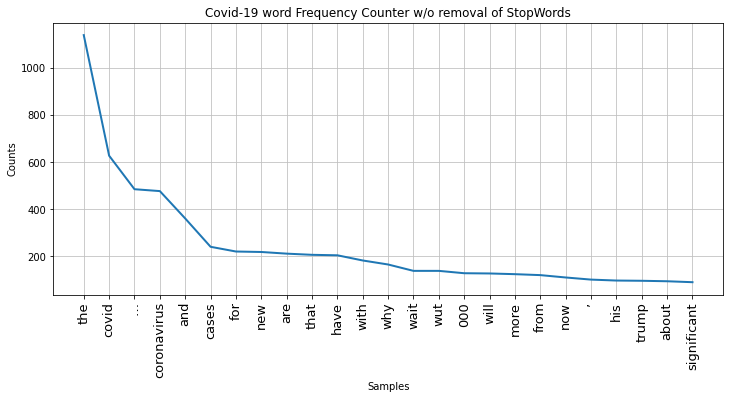

In [17]:
import collections
import nltk
# most common words in twitter dataset
all_words = []
for line in list(df['clean_text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title("Covid-19 word Frequency Counter w/o removal of StopWords")
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

In [18]:
#tweet text word/unique word counts for visualization
df['text_word_count'] = df['clean_text'].apply(lambda x: len(x.strip().split()))  # word count in tweet
df['tweet_unique_words']=df['clean_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in tweet
df.head()

,text,user,location,hashtag,clean_text,polarity,subjectivity,text_word_count,tweet_unique_words
0,"RT @azcentral: JUST IN: The Arizona Department of Health Services told a team of university experts working on COVID-19 modeling to ""pause""…",DesertCarmen,"Chandler, AZ",[],just the arizona department health services told team university experts working covid modeling pause …,0.000000,0.000000,15,15
1,RT @FOX5Vegas: UPDATE: Drive-thru COVID-19 is underway at the Orleans hotel-casino. @dylankendricktv explains how the appointment-only test…,charlienicole,"Nevada, USA",[],update drive thru covid underway the orleans hotel casino explains how the appointment only test…,0.000000,1.000000,15,14
2,"RT @JenningsK12: @CareSTLHealth has created a new COVID-19 testing site at Fairview Elementary School, 7047 Emma Ave, St. Louis, MO 63136.…",CareSTLHealth,St. Louis,[],has created new covid testing site fairview elementary school 7047 emma ave louis 63136 …,0.218182,0.677273,15,15
3,RT @InclusionPhilly: Thanks to @nbcphiladelphia and @mitchreports for a great interview profiling our efforts at @theFPCN to expand testing…,mitchreports,"Philadelphia, PA",[],thanks and for great interview profiling our efforts expand testing…,0.500000,0.475000,10,10
4,"RT @WSJ: Covid-19 is taking workplace surveillance to a higher level, with some employers planning to track movements and gather personal i…",KELLYCLELLAND1,Lothian,[],covid taking workplace surveillance higher level with some employers planning track movements and gather personal …,0.125000,0.400000,16,16


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    1500.000000
mean       14.796000
std         6.091452
min         1.000000
25%        12.000000
50%        15.000000
75%        18.000000
max        40.000000
Name: text_word_count, dtype: float64

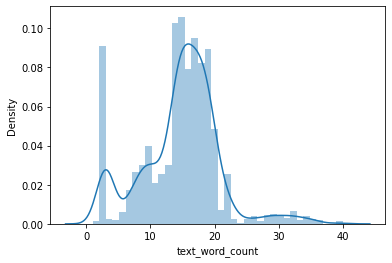

In [19]:
import seaborn as sns
sns.distplot(df['text_word_count'])
df['text_word_count'].describe()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


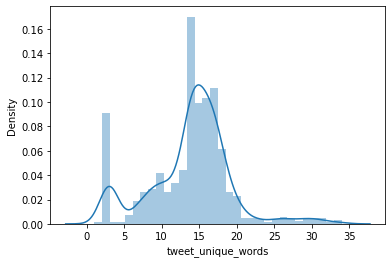

In [20]:
sns.distplot(df['tweet_unique_words'])

 - Interesting Bimodal trend observed
 - ~3 word we see a peak and also ~ 12 words we see a larger peak. These could possibly be sourced to popular retweeted coronavirus data

# SpaCy tokenizer
# Features
* Non-destructive tokenization
* pretrained word vectors
* State-of-the-art speed
* Easy deep learning integration
* Convenient mapping for str --> hash
* Robust, rigorously evaluated accuracy




In [21]:
# Load English tokenizer/word vectors
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [22]:
#NLP: 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #importing module stopwords
import en_core_web_sm #importing pretrained model for tokenization
import string
punctuations = string.punctuation #stripping string punctuation from twitter data
stopwords = list(STOP_WORDS)
stopwords[:10]

['further',
 'call',
 'thereby',
 'mostly',
 '’re',
 'five',
 'yourself',
 'its',
 'except',
 'becomes']

- this includes broken words that are commonly seen in these types of data such as her's , should've. Additionally we elected to filter out some custom stopwords that are coronavirus related
# Custom Stop Words removal 
- we filter our all words that have to do with coronavirus in order to understand the discussion surrounding it 
- Although we lose the context of word features here, our vectorization technique (Tf-IDF) will not need to consider the context in order to graphically represent our data

In [23]:
####### custom_stop_words removal
custom_stop_words = [ '...',',','000','"', 'the', "-",
    'covid','coronavirus','covid-19','coronavirus','virus','COVID','CoronaVirus','Coronavirus','Covid-19','covid-19']

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

#Spacy Tokenization 
- lemmatization 
- custom stopword removal

In [24]:
nlp = en_core_web_sm.load(disable=['tagger','ner'])
nlp.max_length = 8000000
# defining a function for our tokenizer
def spacy(tweet):
    tokens = nlp(tweet)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ] #lemmatizing our tokens
    tokens = [ word for word in tokens if word not in stopwords and word not in punctuations ] #removing stopwords and punctuation
    tokens = " ".join([i for i in tokens]) #joining our tokens with a whitespace
    return tokens

In [25]:
from tqdm import tqdm
tqdm.pandas()
#applying the tokenizer and creating a "processed_text" column from this
df["processed_text"] = df["clean_text"].progress_apply(spacy)

100%|██████████| 1500/1500 [00:05<00:00, 286.75it/s]


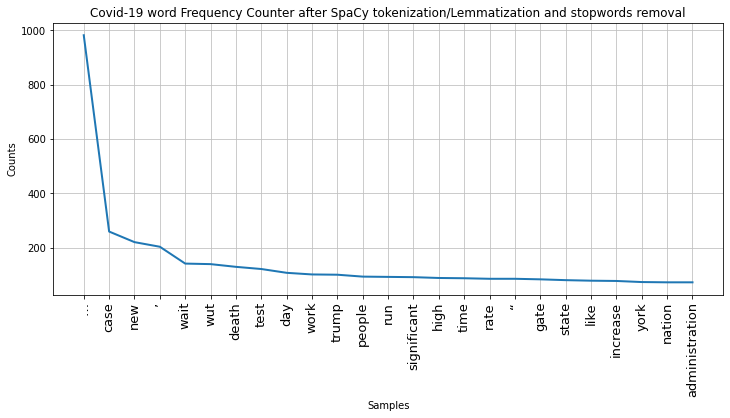

In [26]:
# most common words in processed twitter data
all_words = []
for line in list(df['processed_text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title("Covid-19 word Frequency Counter after SpaCy tokenization/Lemmatization and stopwords removal")
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# Then we use move into ML process: 
* vectorize data
* PCA
* kmeans 
* Dimensionality Reduction with t-SNE
* visualize

Vectorizing Processed Text:

Following feature_engineering and preprocessing, we need to numerically transform the data into a format that can be handled by our K-means algorithm. These vectors will have to be mapped into a lower dimension via dimensionality reduction(PCA) and t-SNE
#BOW 
maps feature vector by scoring 1 if word in vocab is also in the sentences: else a zero will be entered forming a sparse 2d-array. 

# tf-idf. 
* converts string into a measure of how important each word is to the instance out of the tweet as a whole.


Word Embedding is a NLP technique for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions. Word embeddings can be generated using NN's or probabilistic models. 



In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer #creating a vectorize function for our text data
def vectorize(text, max_features):
    
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(text)
    return X

In [28]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
#CountVectorizer followed by TfidfTransformer.
text = df['processed_text'].values
X = vectorize(text, 1195) #1195 features derived from Interactive plot on Kmeans clustering using Tf-IDF
## Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause
#Options:
#  -h, --help            show this help message and exit
#  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
#  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
#  --no-idf              Disable Inverse Document Frequency feature weighting.
#  --use-hashing         Use a hashing feature vectorizer
#  --n-features=N_FEATURES
#                        Maximum number of features (dimensions) to extract
#                        from text.
#  --verbose             Print progress reports inside k-means algorithm.
#1500 documents

#Extracting features from the training dataset using a sparse vectorizer
#done in 0.024959s
#n_samples: 1500, n_features: 1195
X.shape

(1500, 1195)

In [29]:
X # this produced a sparse matrix. We mentioned that these vectors have high computational loss in the context of 
#t-SNE and tf-IDF but we will wait after Dimensionality reduction to see, visually how our data responds.

<1500x1195 sparse matrix of type '<class 'numpy.float64'>'
	with 11602 stored elements in Compressed Sparse Row format>

#Dimensionality Reduction
Principal Component Analysis: used to reduce the dimensions of our Tf-Idf vectorized features while maintaining 90% variance. This number percentage was lowered from 95 in order to obtain a ~ 50 features (opposed to 379). Going from 1195 dimensions (high), we don't compromise too much info, but hopefully we remove some noisy outliers from our tweitter data, in order to make the clustering process easier for k-means.


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90, random_state=42) #90
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape #decreasing n_components or variance in this datframe also led to a decrease in our feature vector. 

(1500, 290)

#K-Means Clustering
this is an unsupervised learning algorithm that will use the elbow curve method to plot distortion vs the number of clusters K. This allows are data to be naturally segregated solely based on our vectorized text. The algorithm is distance-based and tries to simply minimize the SSE (intra or within-cluster variation) to produce coherent clusters.   
For tweet distinction, k-means will be run on the 
vectorized text. 
 


Following clustering, we would like to measure things such as precision, recall and accuracy of our model. 
Precision corresponds to the True Positive rate over all observations that were classified as positive. 
Recall corresponds to the true positive rate over the (true positive and False Negative) cases.
Centroids for clusters are ranndomly initialized and updated iteratively.  

- KMeans is an unsupervised learning algorithm so the model will not distinguish between what the true validity of our class labels actually are. The whole point of this experiment is to work without labeled data to view information transmission of tweets solely on a textual basis. Therfore, innstead of validating our model on things such as LDA key-word topic modeling, we created a dash-app that could allow us to visually asses the coherency of clusters based on content.

In [31]:
from sklearn.cluster import KMeans

We need to find the optimal # of clusters:
finding the best k for k-means requires us viewing the distortion at different k-values.
This simply calculates the sum of squared error from each point to its assigned centroid. Plotting distortion against k shows us which the optimal k and the minimal distortionn. This corresponds to the desired number of clusters


# The Optimal K value will change on much larger datasets which will introduce the need for further hyperparameter tuning given that the number of topics people discuss in a larger dataset will have different implications on the clustering process

In [32]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
# run kmeans with many different k
distortions = []
K = range(1, 40)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(k_means.inertia_)
    #distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k)

Found distortion for 39 clusters


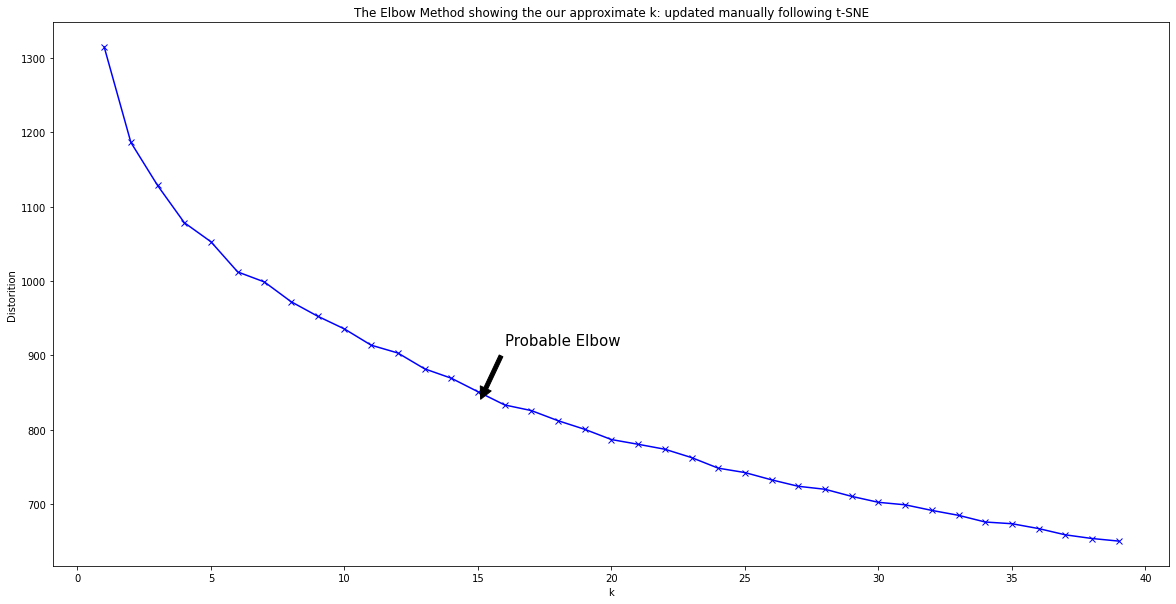

In [33]:
import matplotlib.pyplot as plt
print('Found distortion for {} clusters'.format(k))
# Plot the elbow
plt.figure(figsize=(20,10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorition')
plt.annotate('Probable Elbow',
             xy=(15,distortions[15]),
             xytext=(16,distortions[10]),
             textcoords='data',
             fontsize=15,
             arrowprops=dict(facecolor='black',shrink=0.1))
plt.title('The Elbow Method showing the our approximate k: updated manually following t-SNE')
plt.show()

* The above figure shows us that k values are optimized between 15-20. 
* Following 20 clusters, the decrease in distortion is not as optimally signnificant. 
* we will use 17 for this model

Given that this is an unsupervised algorithm and we have mutliple optimal clusters based on when the data was scraped from twitter [May,1]
This elbow curve is jagged and tells me that I may want to train the model on a different vectorization tool such as Word2Vec

# Running our k-means clustering algorithm 
using our Elbow determined k valuem, we can now run a baseline k-means model on the X_reduced data (PCA).


In [34]:
k = 17 
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y_pred'] = y_pred

# t-Stochastic-Neihbor Embedding was then imported from the sklearn manifold package in order to visually map our 290 features to a 2 dimensional plane. 
By minimizing the KL divergence between joint probabilities of the low-dimensional embedding(1500,290) and the high-dimensional data(1500,1195), X and X_reduced. 
t-SNE's is l(N^2) so it will keep most of the words that we want without being too large to process. 


* t-SNE will use the original feature vector X(1500,1195) that was obtained via tf-idf on the preprocessed text.

Following this, we have a visual representation of our tweets!



The goal of this principle is to reduce our high dimensional features vector to 2 dimensions. We can plot the tweets themselves by using these dimensions as x,y coordinates. In otherwords,similar tweets will ideally be close together, and dissimilar ones farther apart.
This algorithm is apart of the sklearn.manifolds package and had to hyperparameters that we considered for tuninng. Perpelexity (number of nearest neighbors: large # tweets, higher value > 30) 
perplexity : float, optional (default: 30). we chose to reduce this value to ten in order to account for the smaller number of observations in our dataset. We still wanted some leniency between t-SNE's representation and tweets clusteral coherency, so early_exaggeration was slightly reduced from 12 to 10. This resulted in a more balanced model overall that allowed for the possibility of dissimilarity between tweets. In otherwords, RT information would be extremely close in space, but unique tweets would have the opportunity to be more spread out.   

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10, random_state=42, verbose=1, early_exaggeration=10)
X_embedded = tsne.fit_transform(X.toarray()) #the KL divergence reduced from 81.79 (250 iter) to 01.41 after 1000 iterations.
#The model did not take nearly long as I expected and did fairly well with mapping clusters.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.191s...
[t-SNE] Computed neighbors for 1500 samples in 5.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.787941
[t-SNE] KL divergence after 1000 iterations: 1.419042


Let's visualize our compressed data on 2 dimensions:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


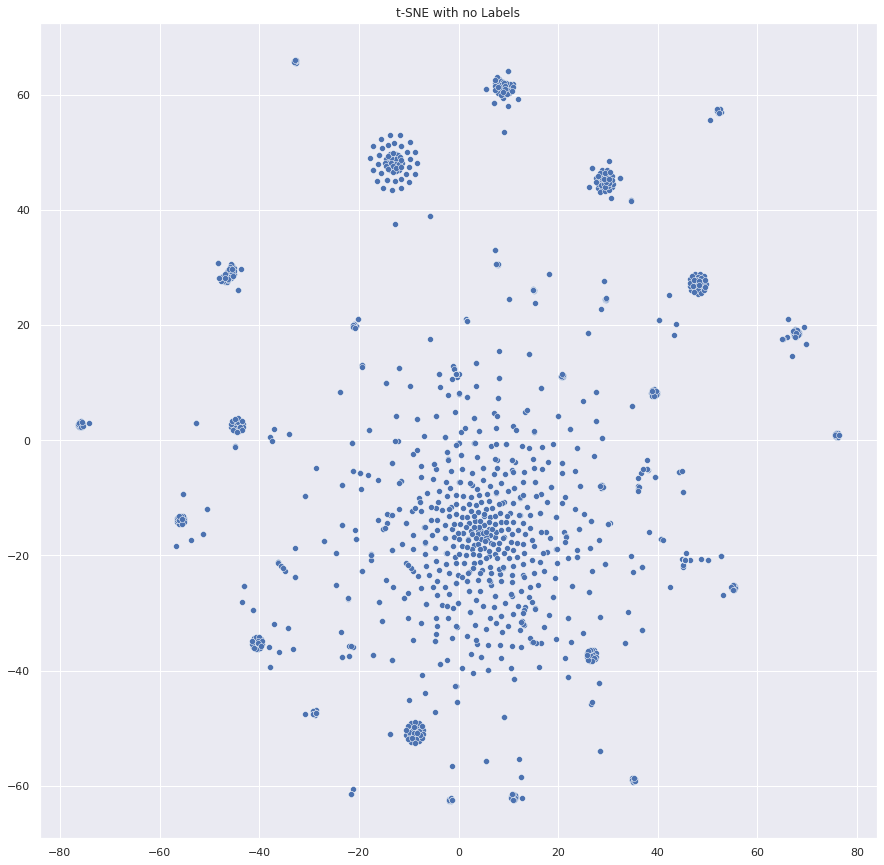

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

#t-SNE with no labels
There's approximately 16 natural cluster that we can immediately recognize. t-SNE did well in terms of dimensionality reduction, but labeled data generated by our k-means clustering algorithm could help us in opening up the hood and examining our tweets through this lens. We will use the clusters developed by kmeans in order to generate labels in order to help visually separate different tweets regarding different topics

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


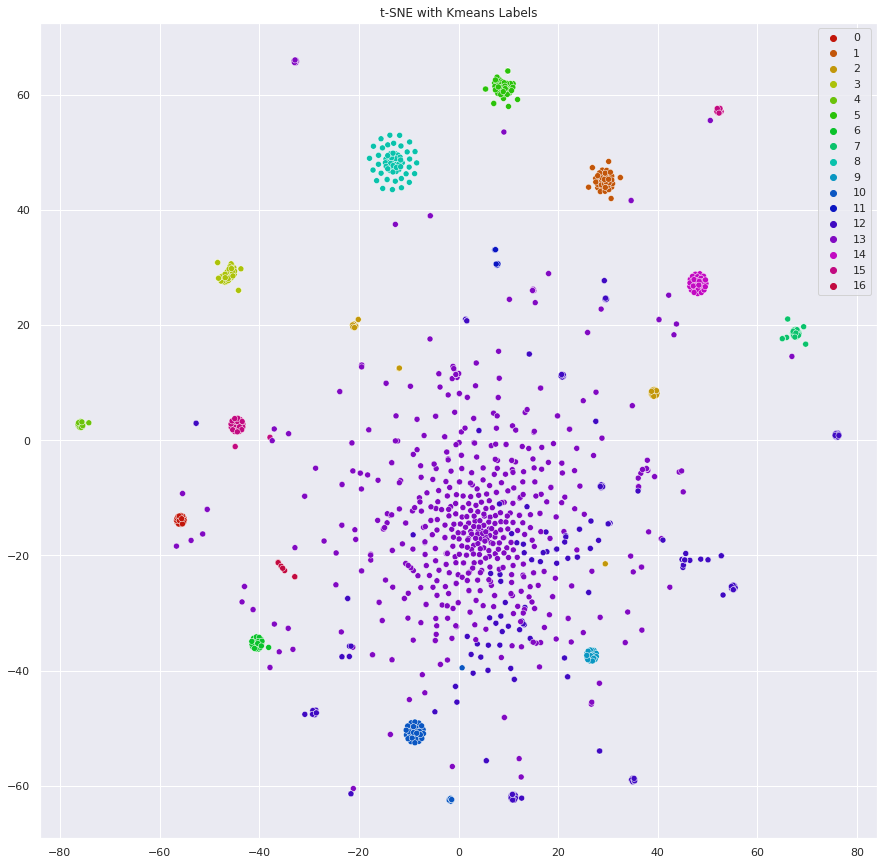

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(17, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("t-sne_wkmeans label.png")

plt.show()

In [38]:
df.head()
df_3 = df[df['y_pred']==13] #viewing subsets of our dataframe to assess how well the model did
df_3.head()

,text,user,location,hashtag,clean_text,polarity,subjectivity,text_word_count,tweet_unique_words,processed_text,y_pred
1,RT @FOX5Vegas: UPDATE: Drive-thru COVID-19 is underway at the Orleans hotel-casino. @dylankendricktv explains how the appointment-only test…,charlienicole,"Nevada, USA",[],update drive thru covid underway the orleans hotel casino explains how the appointment only test…,0.000000,1.000000,15,14,update drive underway orleans hotel casino explain appointment test …,13
2,"RT @JenningsK12: @CareSTLHealth has created a new COVID-19 testing site at Fairview Elementary School, 7047 Emma Ave, St. Louis, MO 63136.…",CareSTLHealth,St. Louis,[],has created new covid testing site fairview elementary school 7047 emma ave louis 63136 …,0.218182,0.677273,15,15,create new test site fairview elementary school 7047 emma ave louis 63136 …,13
3,RT @InclusionPhilly: Thanks to @nbcphiladelphia and @mitchreports for a great interview profiling our efforts at @theFPCN to expand testing…,mitchreports,"Philadelphia, PA",[],thanks and for great interview profiling our efforts expand testing…,0.500000,0.475000,10,10,thank great interview profile effort expand test …,13
6,RT @PhilippineStar: Pilipinas Shell Petroleum Corp. is temporarily shutting down its refinery operations in Batangas for one month to condu…,patoootiie,R,[],pilipinas shell petroleum corp temporarily shutting down its refinery operations batangas for one month condu…,-0.155556,0.288889,15,15,pilipinas shell petroleum corp temporarily shut refinery operation batangas month condu …,13
10,#coronavirus #COVID__19 French hospital discovers Covid-19 case from December https://t.co/ycUZWMtAEl,Kathy_1267,NaN,"[#coronavirus, #COVID__19]",french hospital discovers covid case from december,0.000000,0.000000,7,7,french hospital discover case december,13


The code below regarding LDA was not pertinent to our study and was simply carried over from @inproceedings{COVID-19 Literature Clustering, in order to ease the integration of the Bokeh interactive dash app.
    author = {Eren, E. Maksim. Solovyev, Nick. Nicholas, Charles. Raff, Edward},
    title = {COVID-19 Literature Clustering},
    year = {2020},
    month = {April},
    location = {University of Maryland Baltimore County (UMBC), Baltimore, MD, USA},
    note={Malware Research Group},
    url = {\url{https://github.com/MaksimEkin/COVID19-Literature-Clustering}},
    howpublished = {TBA}
}


In [39]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = []
    
for ii in range(0, 17):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=0, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
#vectorize  data from each of our clusters
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y_pred'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
len(vectorized_data)
#Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). 
#This is a generative statistical model that allows sets of words to be explained by a shared topic
# number of topics per cluster
num_t_per_cluster = 5 #4

lda_models = []
for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=num_t_per_cluster, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

#Extracts each cluster keywords
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values


all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

all_keywords[0][:20]

Not enough instances in cluster: 0
Not enough instances in cluster: 1
Not enough instances in cluster: 3
Not enough instances in cluster: 5
Not enough instances in cluster: 8
Not enough instances in cluster: 9
Not enough instances in cluster: 14


['rush',
 'reopen',
 'bad',
 'horse',
 'tucker',
 'chinese',
 'country',
 'people',
 'die',
 'disease',
 'medium',
 'add',
 'carlson',
 'warn',
 'read']

#Dash app
Generating a Bokeh interactive dash app to visualize our data. Note that this process has been refined and modified from the Covid-19 Literature Clustering challenge. Only slight changes such as the removal of the slider (# of clusters) and keywords generated from LDA were removed.

In [40]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [41]:
import pickle

pickle.dump(df, open("df.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

In [42]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Testing Set)", y_test, sgd_pred)
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

X_train size: 1200
X_test size: 300 

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  98.250 %
     Precision:  99.303 %
        Recall:  99.389 %
      F1 score:  99.342 %
Stochastic Gradient Descent Report (Testing Set) :

Accuracy Score:  91.000 %
     Precision:  88.778 %
        Recall:  89.184 %
      F1 score:  88.616 %
Mean cv Score - SGD: 98.800 %


In [43]:
!pip install lib

  Created wheel for lib: filename=lib-3.0.0-cp36-none-any.whl size=3213 sha256=4b1d2cf052aece01f8b2921ddf2e01c6d6bd62444daa086d290ee0459b162fda
  Stored in directory: /root/.cache/pip/wheels/52/de/da/0ef2064c4b4a213d27518228ebd79a2349e1b81341b05f7196
Successfully built lib


In [44]:
# required libraries for plot
#from lib.plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
#from lib.call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [45]:
# from google.colab import files
# src = list(files.upload().values())
# open('call_backs.py','wb').write(src)

In [47]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

In [48]:
df.columns

Index(['text', 'user', 'location', 'hashtag', 'clean_text', 'polarity',
       'subjectivity', 'text_word_count', 'tweet_unique_words',
       'processed_text', 'y_pred'],
      dtype='object')

In [49]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['text'],
    authors = df['user'],
    location = df['location'],
    labels = ["C-" + str(x) for x in y_labels],
    # links = df['hashtag']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Tweet", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
   # ("Clean Tweet", "@journal"),
    ("Location", "@abstract")
    # ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering COVID-19 tweets with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend_label = 'labels')
plot.legend.background_fill_alpha = 0.6

In [50]:
#text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
#input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a point to see a tweet.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr))# code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
#slider = Slider(start=5, end=13, value=5, step=1, title="Cluster #", callback=input_callback_1)
#keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
#input_callback_1.args["text"] = keyword
#nput_callback_1.args["slider"] = slider

In [51]:
#slider.sizing_mode = "stretch_width"
#slider.margin=15

#keyword.sizing_mode = "scale_both"
#keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

#text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
#text_banner.sizing_mode = "scale_both"
#text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 13

r = row(div_curr)
r.sizing_mode = "stretch_width"
# LAYOUT OF THE PAGE
l = layout([
    #[slider],# keyword],
    #[text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('plot.html')

In [52]:
show(l)

There's approximately 16 natural clusters that we can immediately recognize. This value was used to update our k-means labels to compensate for our elbow-curve method. t-SNE did well in terms of dimensionality reduction, but labeled data generated by k-means could help us in opening up the hood and examining our tweets through this lens. Clusters developed by k means aided in label generation in order to help visually separate different tweets regarding different topics. t-SNE made a group of all the tweets all together forming a cluster, where the color is the same for the majority of the cluster. Also, there are some deviations in the label generated by k-means and points that are spread out on the chart. This occurs because the labels and the points don’t have do not have proportionate resemblance between themselves and the higher dimensional data. This signifies the computational loss we saw from tf-Idf vectorization most likely. This isn’t all bad because we simply want popular retweets to have a high concentration of coherently clustered and consistently labeled points. Points with more spread probably correspond then, to posts that contain most of the same covid-related keywords(death, cases, test, trump) but are fundamentally different when it comes to modeling information spread. Following this, we generated a Bokeh interactive dash app to visualize our data. Note that this process has been refined and modified from the Covid-19 Literature Clustering challenge. Only slight changes such as the removal of the slider (# of clusters) and keywords generated from LDA were made. [3]
For the following project, our visualization has provided us with the functionality to create an interactive cluster and plots of tweets related to COVID-19. In this cluster highlighted in Figure 10, there is a wide variety of similar tweets which are combined together. With this combination, we can easily determine and analyze the tweets which are related to CoronaVirus. This dashboard will remove the need of manually analyzing the CoronaVirus Tweets and provide the user with an interactive dashboard. The data clustering was done using k-means on data regarding coronavirus tweets. 

As observed in the above graphical image, there are various coherent and incoherent structures being formed by the tweets. An observation about the coherent clusters’ formation is that they occur due to the retweet of the same twitter post without any additional content posted with it. While in the case of incoherent clusters’ formation, there are retweets of the same twitter post but here the retweet is attached with some form of additional information such as text, images, etc. For e.g.:- When we analyze fact-centric tweets such as “CoronaVirus is a global pandemic” will just retweet without any additional information(coherent clusters) but when we analyze opinion-centric tweets such as “Government is failing to take necessary measures during this pandemic” we see the formation of incoherent clusters.

There are some tweets which contain a larger length of text due to which some of the text data inside the retweet is ignored. If we can observe those ignored text data , they would produce some relatively different results. The data contains tweets which contains tweets from May 1st to May 3rd, 2020. If we select a different date, we can also get a different dataset that would create a completely different visualization. When a tweet about CoronaVirus Pandemic is done by a major account such as a celebrity or a politician, they have a better reach and due to that they have a larger cluster around them due to increased number of retweets of their post. The final dashboard application is saved in the HTML format. This file can be accessed by opening the HTML in any supported browser on the user device. The dashboard can be accessed online as well as offline.

Main Idea:
The unsupervised learning approach afforded to us by K-Means, allowed the data to make connections in tweets that are not always so obvious to humans. Closely packed clusters obviously correspond to retweeted information which means our dimensionality reduction, cleaning and modeling approaches were functional to some extent. 
 
# Discussion
By scraping a few thousand COVID related tweets within a specified time range we hoped to give the reader an idea of the transmission of commonly circulated information (Retweets) to understand the spread of articles/rumors/stories/opinions during this time of crisis. The modeling process was inspired by techniques used in the COVID-19 Literature Clustering publication authored by E. Maksim. Solovyev, Nick. Nicholas, Charles. Raff, Edward. [3] The primary difference in their work is its application which clusters academic literature by topic to help health professionals keep up on field-specific information related to the virus. Their idea being that clustering similar research articles could help simplify the search for related publications. 



While some of the modeling and preprocessing techniques were similar to our approach, we have modified and repurposed this motivation to understand how twitter data can be clustered within a given time frame. The clustering of tweets can be better represented in the form of a labeled plot. t-SNE was used to intuitively visualize the optimal number of clusters in our data, which is cheating the model to a certain extent, however upon further review the dimensionality reduction steps seemed to sufficiently cluster together the information in a way that was appropriate visualization. Following PCA and dimensionality reduction, our data was mapped from 1195, to 290 to 2 features respectively. Although t-SNE had an extremely high number of features to map on the coordinate plane, it didn’t seem to compromise too much information in our data. To reiterate on the limitations of our work; the free version of tweepy only allowed us to scrape 1500 tweets every 15 minutes or so which is a very small number of observations for a robust Machine Learning algorithm to be trained on. Furthermore, retweets were displayed in a truncated mode that was followed by an ellipsis character. Additionally it was clear that this form of sharing was extremely popular in our data. This gave a disproportionate amount of weight to retweets given that they contained “...” even after preprocessing. In the future, more extensive data cleaning could be carried out on this work to give us a better idea of the variations and additionally commentary people use for RTs. The use of tf-Idf for vectorization yielded a sparse matrix which is known to have a very high computational loss in the field of textual clustering. Perhaps sentiment analysis  could’ve been investigated in more depth after dimensionality reduction took place but our plates were still full throughout this study. Even in light of all of these shortcomings, our exploration still yielded some pretty remarkable results that fascinated us time and time again.  We will now open the hood of our model and investigate the dash app template in order to make connections between the apparent clusters generated from t-SNE, the k-means labels and data itself.



Following t-SNE we generated a Bokeh interactive dash app to visualize our data. Note that this process has been refined and modified from the Covid-19 Literature Clustering challenge. Only slight changes such as the removal of the slider (# of clusters) and keywords generated from LDA were made. [3]



In this cluster highlighted in Figure 10, there is a wide variety of similar tweets which are combined together. With this combination, we can easily determine and analyze the tweets which are related to CoronaVirus. This dashboard will remove the need for manually scrolling through tweets and provide the user with an interactive dashboard. 
As observed in the above Figure, there are various coherent and incoherent structures being formed by the tweets. An observation about the coherent clusters’ formation is that they occur due to the retweet of the same twitter post without any additional content posted with it. While in the case of incoherent clusters’ formation, there are retweets of the same twitter post but here the retweet is attached with some form of additional information such as text, images, or other embedded metadata.. For example, when we analyze fact-centric tweets such as “CoronaVirus is a global pandemic” we only see retweets without any additional information(coherent clusters) but when we analyze opinion-centric tweets such as “Government is failing to take necessary measures during this pandemic” we see the formation of incoherent clusters.
There are some tweets which contain a larger length of text due to which some of the text data inside the retweet is ignored. If we could access the full ‘extended’ form , we expect them to provide some relatively different results. Our data contains tweets from May 1st to May 3rd, 2020. If we select a different date, we would procure a drastically different data frame that would yield a completely different visualization. That being said, after running the code 40-50 times, we still observed similar patterns in the transmission information. Most of these tweets tended to be politically focused which is consistent with our word Frequency distribution seen in Figure 6. Trump has obviously dominated the social spotlight when it comes to covid. When a tweet is posted by a major, verified such as a celebrity or a politician, they have a better reach and due to that they have a larger cluster around them due to increased number of retweets of their post. The final dashboard application is saved in the HTML format. This file can be accessed by opening the HTML in any supported browser on the user device. The dashboard can be accessed online as well as offline. We hope you enjoyed this exploration as much as we enjoyed making it. 

